ConvLSTM trained on gridded forcings for all stations

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
from sklearn import preprocessing
import netCDF4 as nc
import torch
from torch import nn, utils
from torch.utils.tensorboard import SummaryWriter
from src import load_data, evaluate, conv_lstm, datasets
import torch.autograd as autograd
import pickle

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

In [ ]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../log.out', mode='a')
chandler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s - {} - %(message)s'.format(time_stamp))
fhandler.setFormatter(formatter)
chandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

In [ ]:
USE_CUDA = False
if torch.cuda.is_available():
    print('CUDA Available')
    USE_CUDA = True
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
num_devices = torch.cuda.device_count() if USE_CUDA else 0
logger.warning('cuda devices: {}'.format(list(torch.cuda.get_device_name(i) for i in range(num_devices))))
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
seq_len = 50
seq_steps = 1

train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(hours=seq_len * seq_steps)  # first day for which to make a prediction in train set
train_end = '2012-09-30'
val_start = '2012-10-01'
val_end = '2012-12-31'
test_start = '2013-01-01'
test_end = '2014-12-31'

In [ ]:
rdrs_vars = [4,5]
train_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, train_start, train_end)
val_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, val_start, val_end, conv_scalers=train_dataset.conv_scalers)
test_dataset = datasets.RdrsGridDataset(rdrs_vars, seq_len, seq_steps, test_start, test_end, conv_scalers=train_dataset.conv_scalers)

In [65]:
class ConvLSTMGrid(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTMGrid, self).__init__()
        self.conv = conv_lstm.ConvLSTM((input_size[0], input_size[1]), input_dim, hidden_dim, kernel_size, num_layers, batch_first=True)
        self.linear = nn.Linear(input_size[0] * input_size[1], input_size[0] * input_size[1])
        
    def forward(self, input_tensor, hidden_state=None):
        conv_out, hidden = self.conv(input_tensor, hidden_state=hidden_state)
        return self.linear(conv_out[-1][:,-1,0,:,:].reshape(input_tensor.shape[0], -1)).reshape((input_tensor.shape[0], conv_out[-1].shape[3], conv_out[-1].shape[4])), hidden

In [66]:
# Train model
num_epochs = 40
learning_rate = 2e-3
patience = 100
min_improvement = -1000000#0.05
best_loss_model = (-1, np.inf, None)

# Prepare model
stateful_lstm = False
num_conv_layers = 3
conv_hidden_dims = [8] * (num_conv_layers - 1) + [1]
batch_size = 16
kernel_size = [(3,3), (3,3), (1,1)]

model = ConvLSTMGrid((train_dataset.conv_height, train_dataset.conv_width), train_dataset.n_conv_vars, conv_hidden_dims, kernel_size, num_conv_layers).to(device)
model = torch.nn.DataParallel(model, device_ids=list(range(num_devices)))
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter()
param_description = {'time_stamp': time_stamp, 'H_conv': conv_hidden_dims, 'batch_size': batch_size, 'num_conv_layers': num_conv_layers, 'kernel_size': kernel_size, 'loss': loss_fn, 
                     'optimizer': optimizer, 'lr': learning_rate, 'patience': patience, 'min_improvement': min_improvement, 'stateful_lstm': stateful_lstm, 
                     'num_epochs': num_epochs, 'seq_len': seq_len, 'seq_steps': seq_steps, 'train_start': train_start, 'train_end': train_end, 'val_start': val_start, 
                     'val_end': val_end, 'test_start': test_start, 'test_end': test_end, 'n_conv_vars': train_dataset.n_conv_vars, 'model': str(model).replace('\n','').replace(' ', ''),
                     'train len':len(train_dataset), 'val len': len(val_dataset), 'conv_height': train_dataset.conv_height, 'conv_width': train_dataset.conv_width, 'test len': len(test_dataset)}
writer.add_text('Parameter Description', str(param_description))

In [67]:
if stateful_lstm:
    train_sampler = datasets.StatefulBatchSampler(train_dataset, batch_size)
    val_sampler = datasets.StatefulBatchSampler(val_dataset, batch_size)
    test_sampler = datasets.StatefulBatchSampler(test_dataset, batch_size)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler, pin_memory=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_sampler, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler, pin_memory=True)
else:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True, drop_last=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [77]:
for epoch in range(num_epochs):
    model.train()

    epoch_losses = torch.tensor(0.0)
    conv_hidden_states = None
    for i, train_batch in enumerate(train_dataloader):
        y_train = train_batch['y'].reshape(-1).to(device, non_blocking=True)
        mask = train_batch['mask'].reshape(-1).to(device, non_blocking=True)
        if mask.sum() == 0:
            print('Batch {} has no target values. skipping.'.format(i))
            continue
        if not stateful_lstm:
            conv_hidden_states = None
        
        y_pred, conv_hidden_states = model(train_batch['x_conv'].to(device), hidden_state=conv_hidden_states)
        #y_pred = y_pred[-1][:,-1,0,:,:].reshape(-1) # last output of last layer (which has only 1 dimension anyways)
        y_pred = y_pred.reshape(-1) * mask  # ignore grid cells that have no target value
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses += (loss * y_train.shape[0] / mask.sum()).detach()  # only average over losses where we had a target
        
    epoch_loss = (epoch_losses / len(train_dataloader)).item()
    print('Epoch', epoch, 'mean train loss:\t{}'.format(epoch_loss))
    writer.add_scalar('loss', epoch_loss, epoch)
    
    # eval on validation split
    model.eval()
    val_losses = torch.tensor(0.0)
    for i, val_batch in enumerate(val_dataloader):
        y_val = val_batch['y'].reshape(-1).to(device, non_blocking=True)
        mask = val_batch['mask'].reshape(-1).to(device, non_blocking=True)
        if not stateful_lstm:
            conv_hidden_states = None
        
        batch_pred, conv_hidden_states = model(val_batch['x_conv'], hidden_state=conv_hidden_states)
        #batch_pred = batch_pred[-1][:,-1,0,:,:].detach().reshape(-1)
        batch_pred = batch_pred.detach().reshape(-1)
        val_losses += (loss_fn(batch_pred * mask, y_val).detach() * y_val.shape[0] / mask.sum())
        
    val_mse = (val_losses / len(val_dataloader)).item()
    print('Epoch {} mean val mse:    \t{}'.format(epoch, val_mse))
    writer.add_scalar('loss_eval', val_mse, epoch)

    if val_mse < best_loss_model[1] - min_improvement:
        best_loss_model = (epoch, val_mse, model.state_dict())  # new best model
        load_data.pickle_model('ConvLSTM_VIC', model, 'allStations', time_stamp)
    elif epoch > best_loss_model[0] + patience:
        print('Patience exhausted in epoch {}. Best val-loss was {}'.format(epoch, best_loss_model[1]))
        break

print('Using best model from epoch', str(best_loss_model[0]), 'which had loss', str(best_loss_model[1]))
model.load_state_dict(best_loss_model[2])
load_data.pickle_model('ConvLSTM_VIC', model, 'allStations', time_stamp)

Epoch 0 mean train loss:	1218.2711181640625
Epoch 0 mean val mse:    	4107.951171875
Saved model as ../pickle/models/ConvLSTM_VIC_allStations_20190722-201640.pkl


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvLSTMGrid. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1 mean train loss:	997.1013793945312
Epoch 1 mean val mse:    	3793.3408203125
Saved model as ../pickle/models/ConvLSTM_VIC_allStations_20190722-201640.pkl
Epoch 2 mean train loss:	884.4265747070312
Epoch 2 mean val mse:    	3618.656005859375
Saved model as ../pickle/models/ConvLSTM_VIC_allStations_20190722-201640.pkl
Epoch 3 mean train loss:	858.3435668945312
Epoch 3 mean val mse:    	3490.84521484375
Saved model as ../pickle/models/ConvLSTM_VIC_allStations_20190722-201640.pkl
Epoch 4 mean train loss:	719.06103515625
Epoch 4 mean val mse:    	3333.2119140625
Saved model as ../pickle/models/ConvLSTM_VIC_allStations_20190722-201640.pkl


KeyboardInterrupt: 

In [78]:
logger.warning('predicting')
model.eval()

predictions = []
for i, test_batch in enumerate(test_dataloader):
    if not stateful_lstm:
        conv_hidden_states = None
        
    pred, conv_hidden_states = model(test_batch['x_conv'], hidden_state=conv_hidden_states)
    #predictions.append(pred[-1][:,-1,0,:,:].detach())
    predictions.append(pred.detach())
    
predictions = torch.cat(predictions).cpu()

if stateful_lstm:
    # reorder time series
    pred_indices = np.array(list(test_sampler.__iter__())).reshape(-1)
    predictions = predictions[pred_indices.argsort()]

2019-07-23 09:57:07,278 - 20190722-201640 - predicting


04159492 	NSE: 0.014496671968792896 	MSE: 457.5630877925969 (clipped to 0)
04199000 	NSE: -0.02285227645467547 	MSE: 1045.9721130960047 (clipped to 0)
02GG002 	NSE: 0.04542433621812325 	MSE: 230.22725662991172 (clipped to 0)
04213500 	NSE: 0.05832956449198112 	MSE: 964.6630550818561 (clipped to 0)
02GA038 	NSE: -0.05463583470762856 	MSE: 173.52815286477176 (clipped to 0)
04198000 	NSE: 0.0007977905074953995 	MSE: 7381.665677170289 (clipped to 0)
04197100 	NSE: -0.010661179384840569 	MSE: 103.65786731412508 (clipped to 0)
04215500 	NSE: 0.044418765872625054 	MSE: 172.56355264062574 (clipped to 0)
02GB007 	NSE: -0.08377058546569383 	MSE: 33.89168949448496 (clipped to 0)
04165500 	NSE: -0.22036987127872854 	MSE: 546.3094561039078 (clipped to 0)
02GG013 	NSE: -0.19482551722661667 	MSE: 45.62128208201607 (clipped to 0)
02GC002 	NSE: -0.007968968224383977 	MSE: 129.52707122012086 (clipped to 0)
04212100 	NSE: -0.024430526452463353 	MSE: 1504.1969909902496 (clipped to 0)
04199500 	NSE: -0.035

../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: Ru

02GC026 	NSE: 0.047450757244495656 	MSE: 153.201117405824 (clipped to 0)
02GC007 	NSE: -0.03574086662783382 	MSE: 31.197907429300578 (clipped to 0)
04193500 	NSE: -0.1536870436903799 	MSE: 81681.90711387475 (clipped to 0)
04174500 	NSE: -0.6229447612405385 	MSE: 153.48876181525085 (clipped to 0)
02GC010 	NSE: 0.038865400110420834 	MSE: 57.13937487935254 (clipped to 0)
02GE007 	NSE: -0.044975644685727234 	MSE: 37.80205505629368 (clipped to 0)
02GD004 	NSE: -0.11283844268375454 	MSE: 61.27630486627094 (clipped to 0)


../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: Ru

04214500 	NSE: 0.040718413346629734 	MSE: 115.62900812071112 (clipped to 0)
04213000 	NSE: -0.05340486754815599 	MSE: 189.05376718113828 (clipped to 0)
02GG009 	NSE: -0.2506053808582014 	MSE: 194.53595248751074 (clipped to 0)
02GA010 	NSE: -0.02386524006354729 	MSE: 488.15186345433636 (clipped to 0)
04176500 	NSE: -0.07191046598676398 	MSE: 732.1944015760934 (clipped to 0)
04177000 	NSE: -0.10802302558638166 	MSE: 29.861031966274577 (clipped to 0)
02GA047 	NSE: -0.08736451358993813 	MSE: 85.23853103978769 (clipped to 0)
02GC018 	NSE: -0.006800145206914188 	MSE: 68.18735381022638 (clipped to 0)
02GB001 	NSE: -0.11969455441762089 	MSE: 8408.766364231164 (clipped to 0)
04166500 	NSE: -0.2188401223094507 	MSE: 42.128346324776246 (clipped to 0)
04207200 	NSE: -0.3250840719108099 	MSE: 31.015303777151278 (clipped to 0)
04160600 	NSE: -0.12635180258392764 	MSE: 32.586388764992826 (clipped to 0)


../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: Ru

04215000 	NSE: 0.00834991712920996 	MSE: 95.25077979273848 (clipped to 0)
02GA018 	NSE: 0.0048959086439014365 	MSE: 249.9235574746746 (clipped to 0)
02GG006 	NSE: -0.2085232970513322 	MSE: 64.78560984445502 (clipped to 0)
04200500 	NSE: -0.03318821232172953 	MSE: 1033.9165644558038 (clipped to 0)
04209000 	NSE: -0.07041165932583637 	MSE: 334.67064488367754 (clipped to 0)
04161820 	NSE: -0.47534271487161583 	MSE: 46.58844470597963 (clipped to 0)
Median NSE (clipped to 0) -0.04919025611694161 / Min -0.6229447612405385 / Max 0.05832956449198112
Median MSE (clipped to 0) 173.04585275269875 / Min 7.8918016218070095 / Max 81681.90711387475


../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:42: Ru

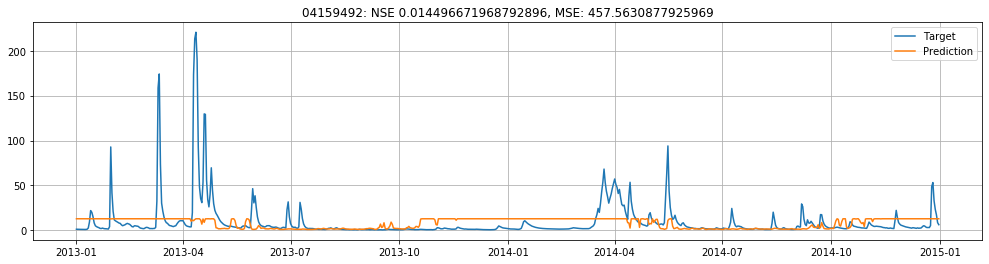

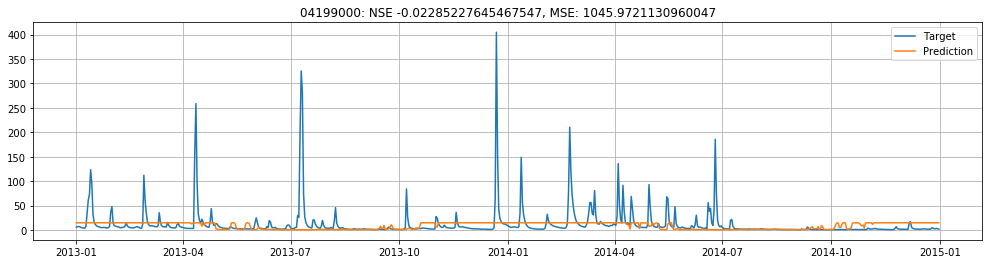

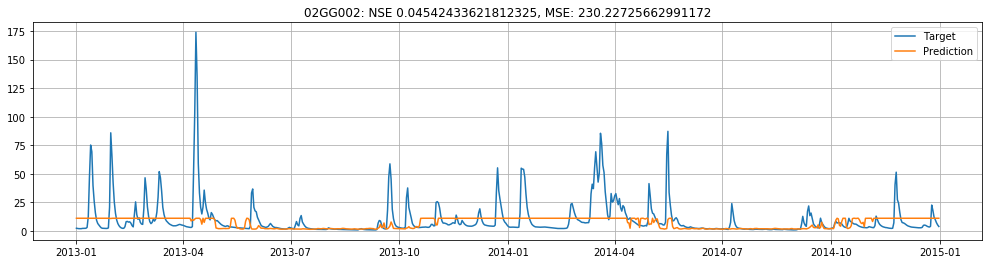

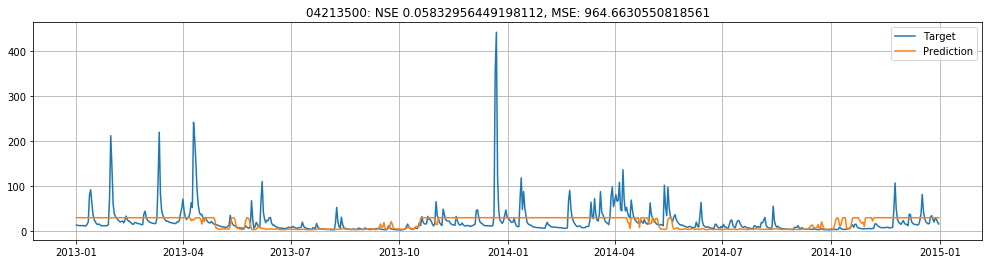

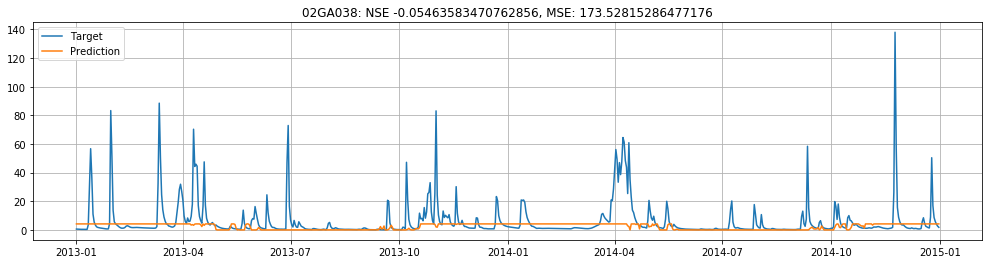

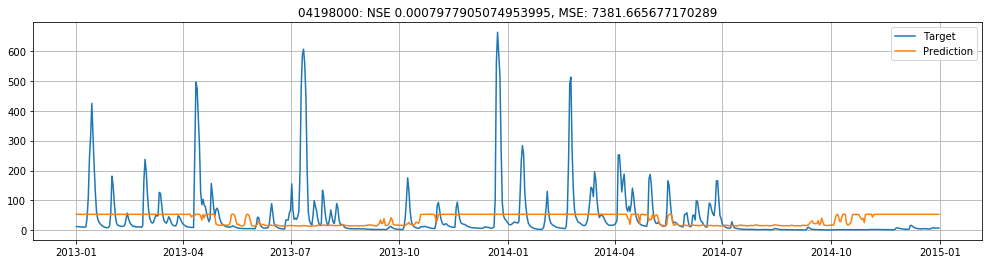

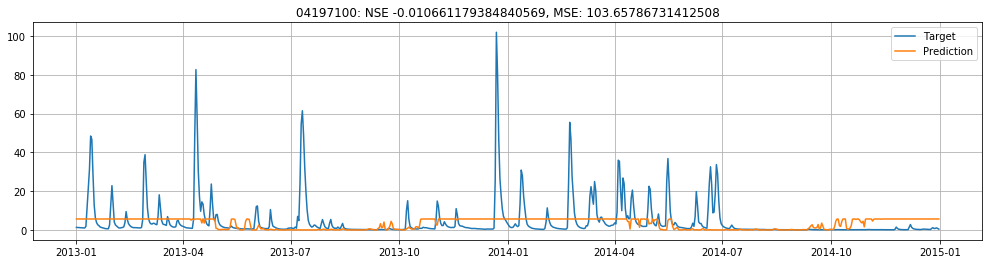

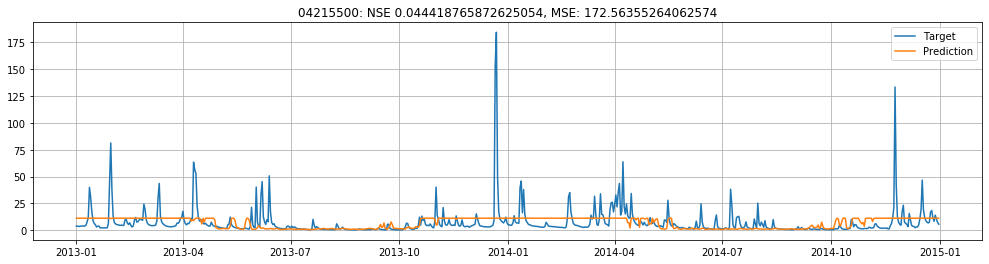

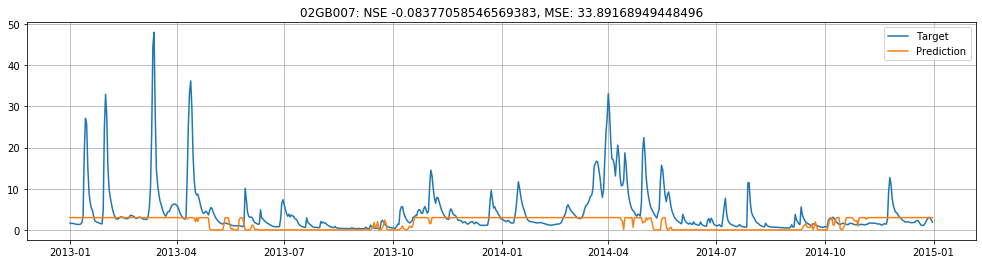

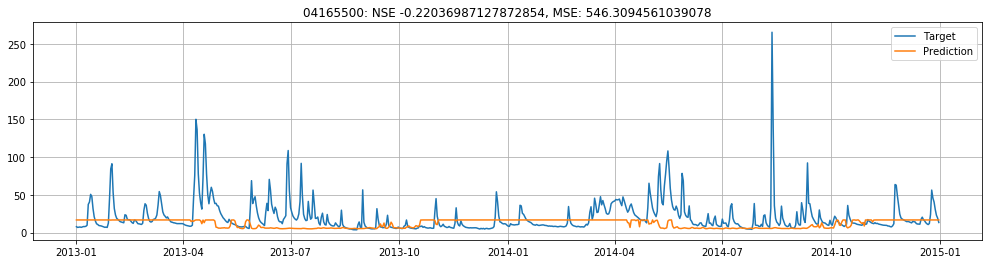

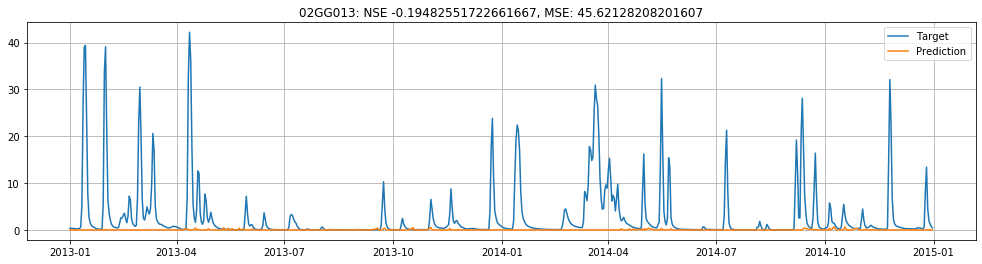

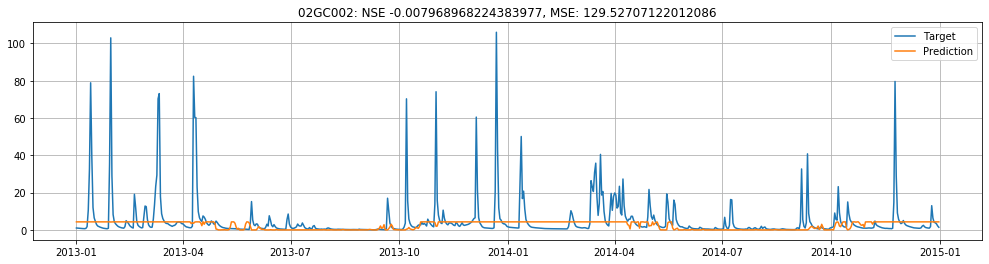

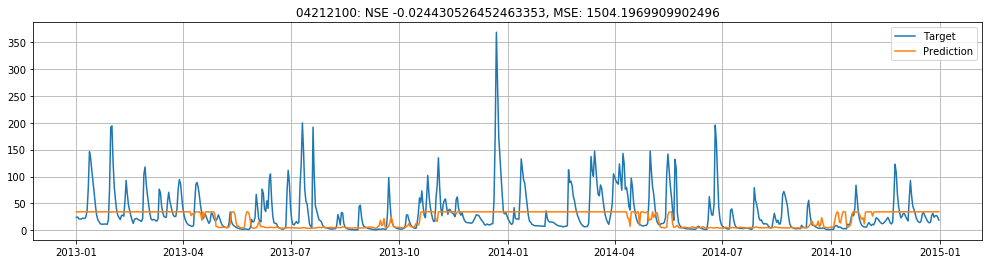

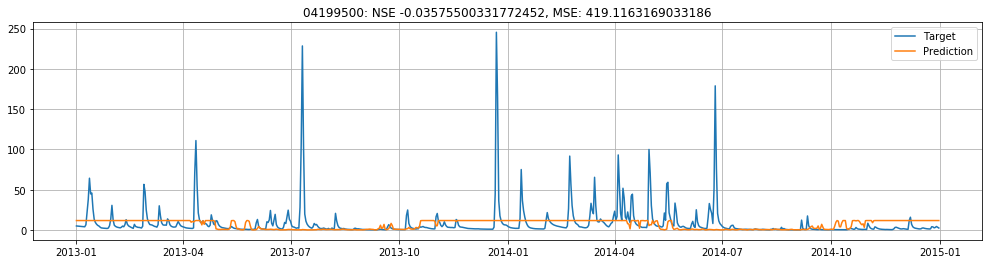

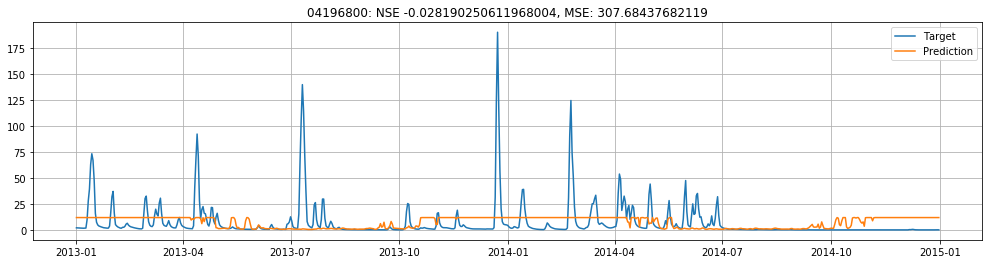

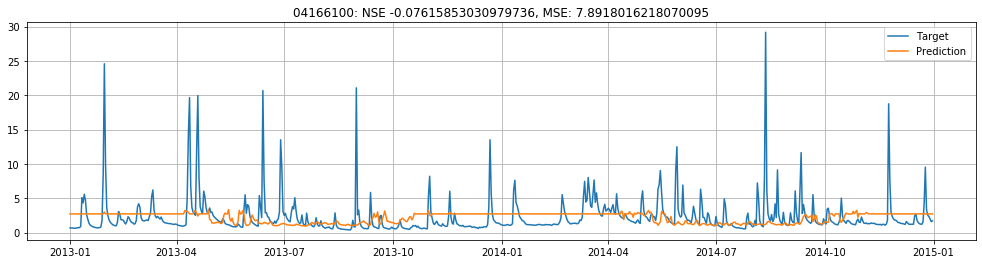

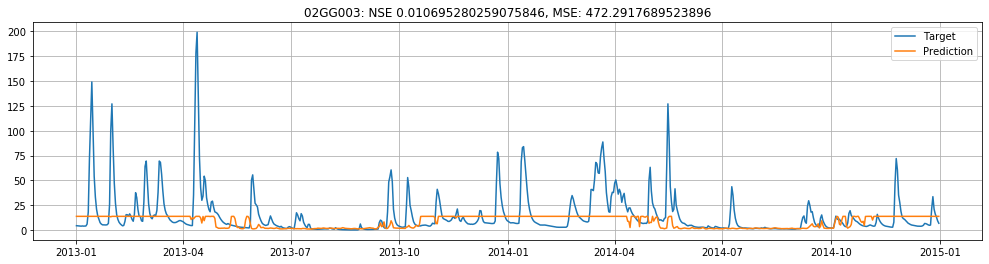

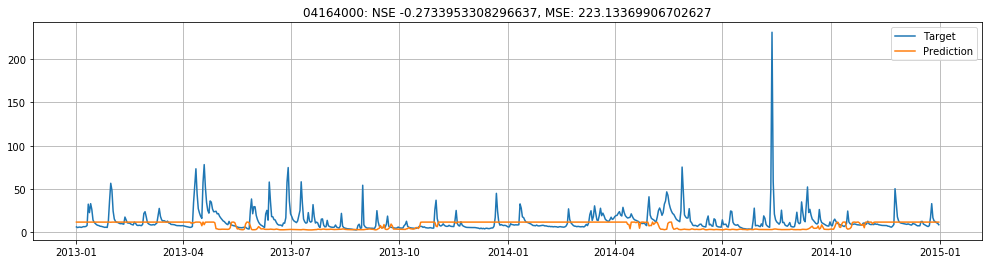

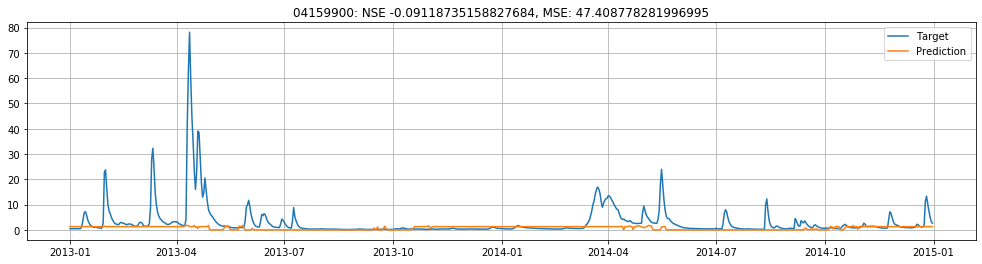

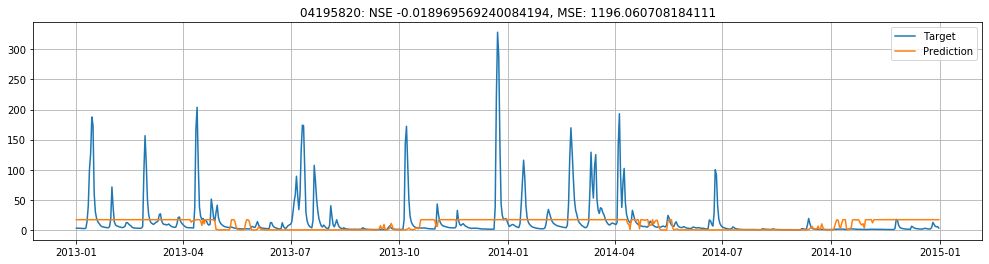

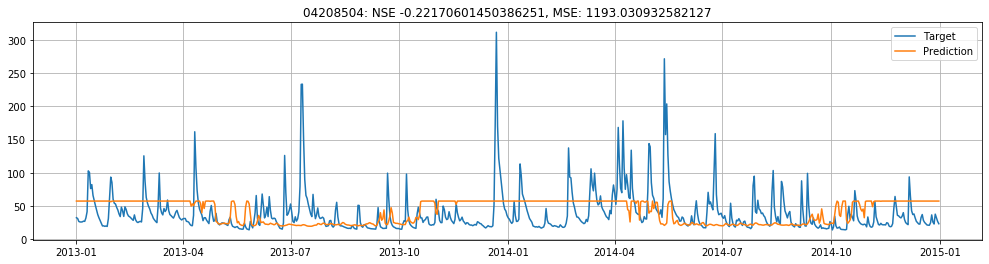

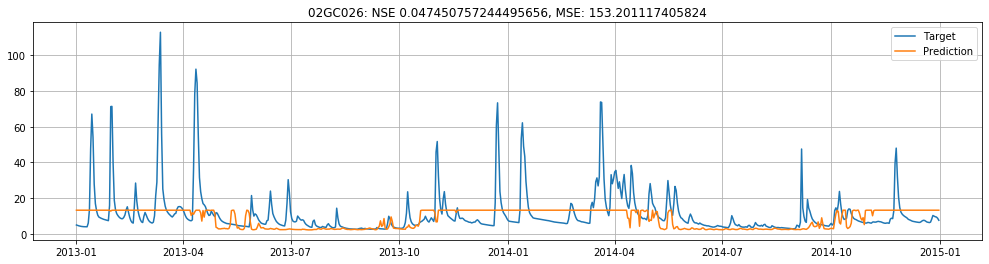

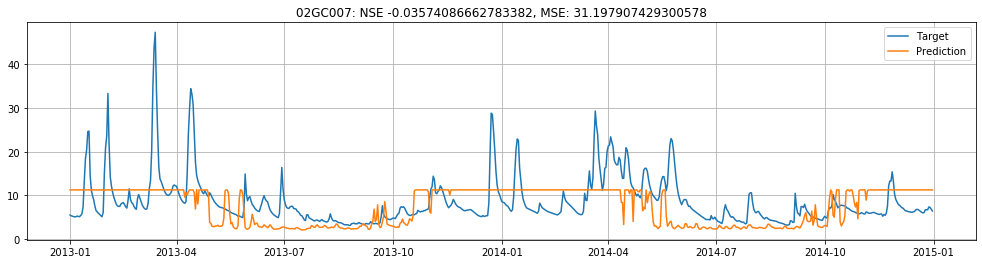

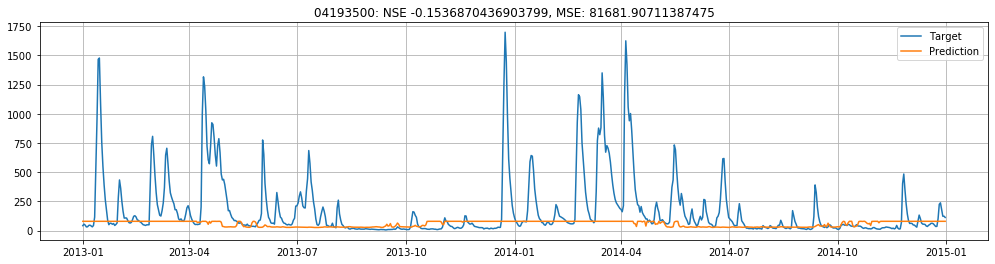

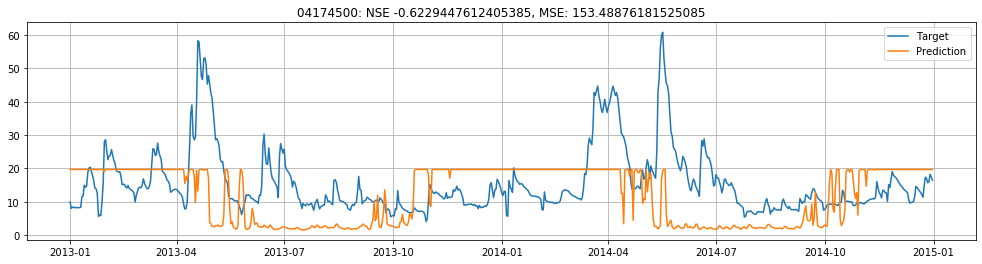

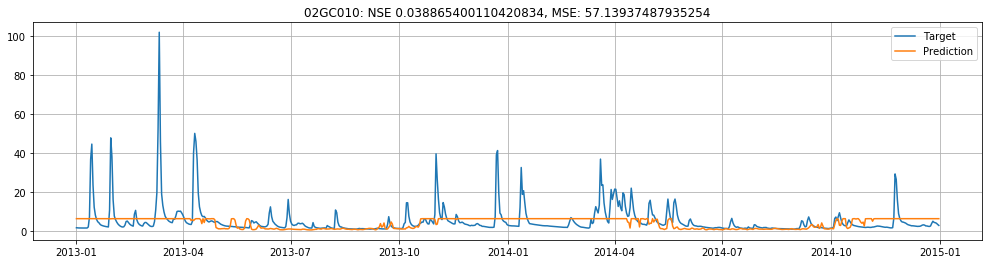

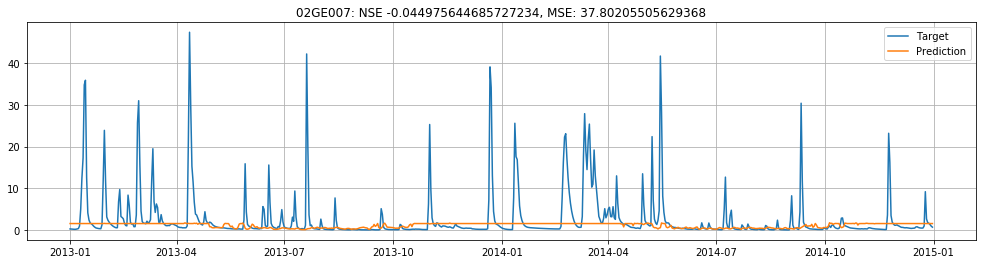

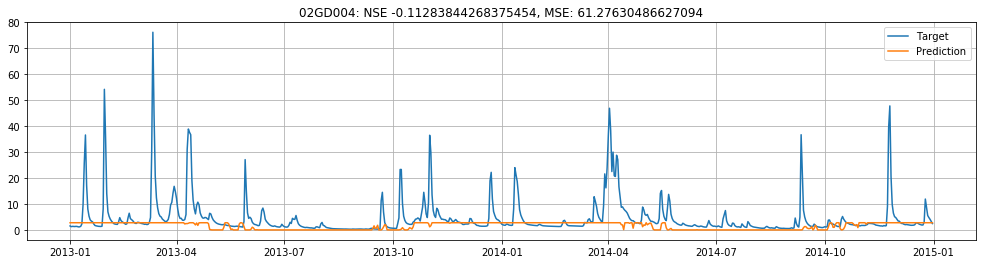

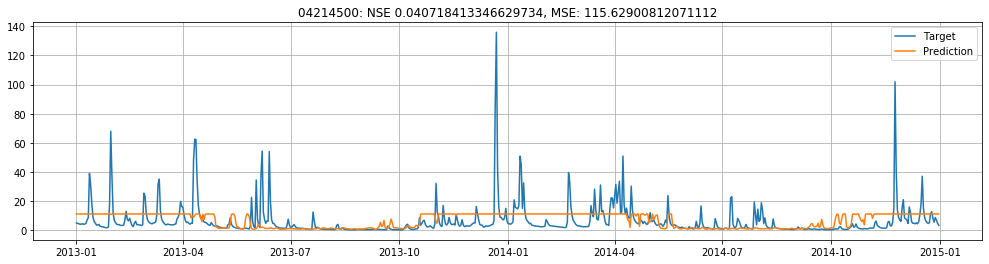

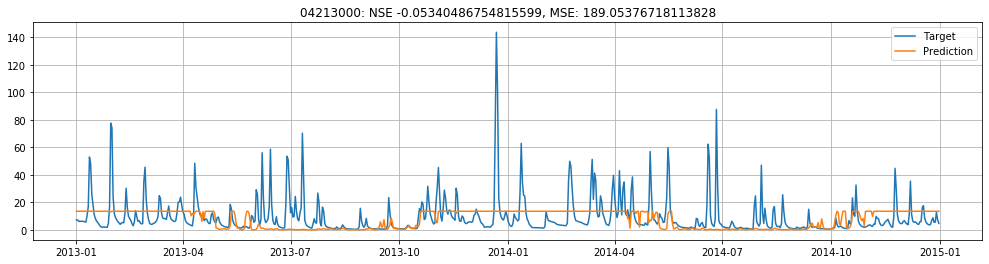

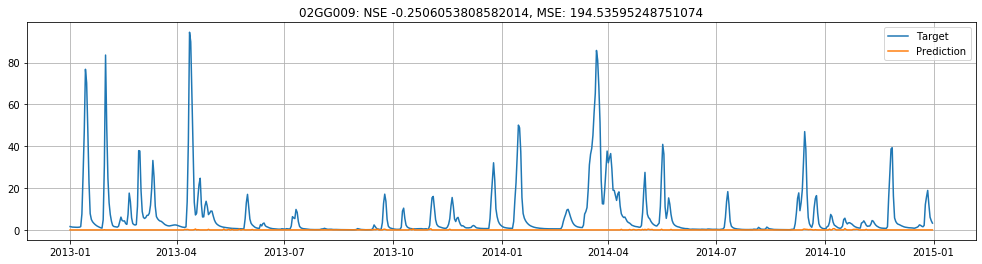

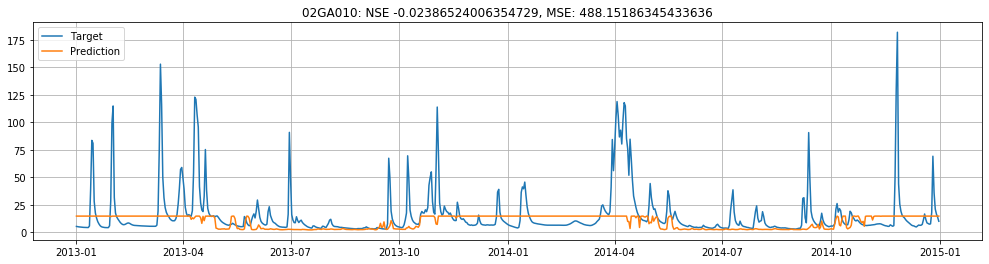

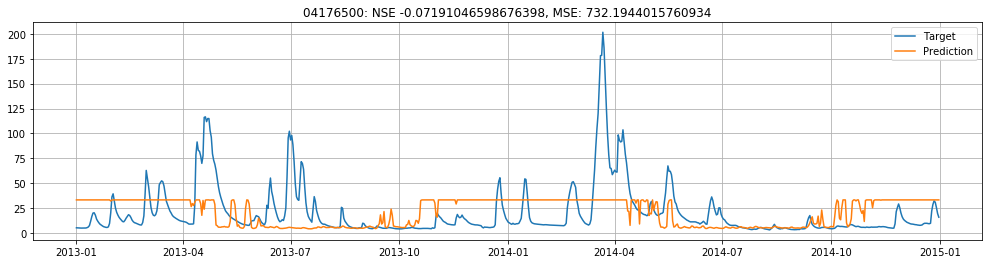

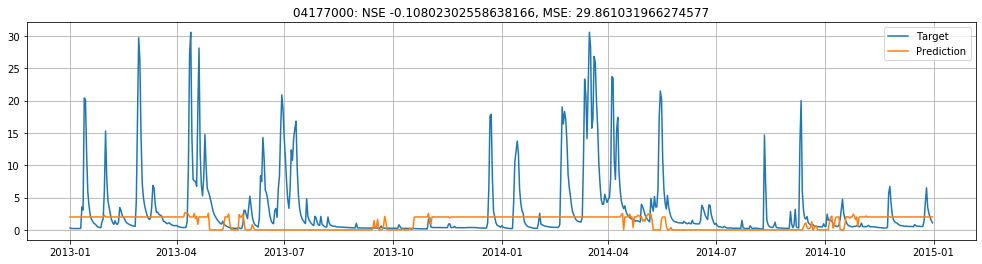

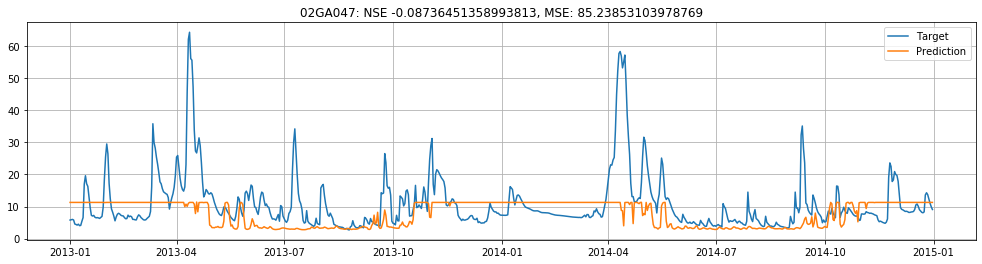

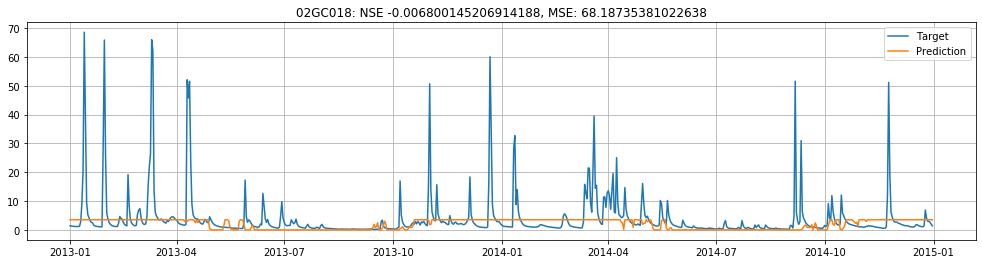

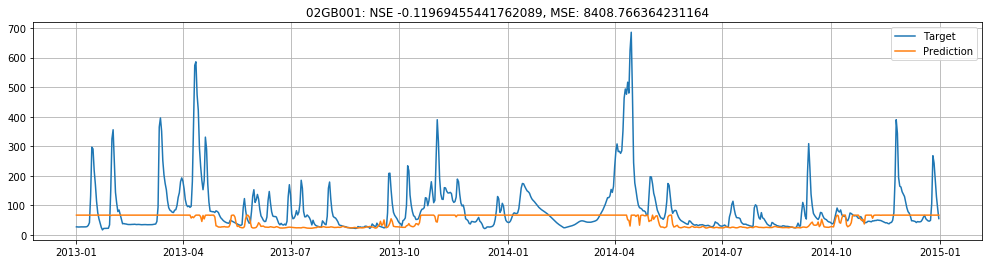

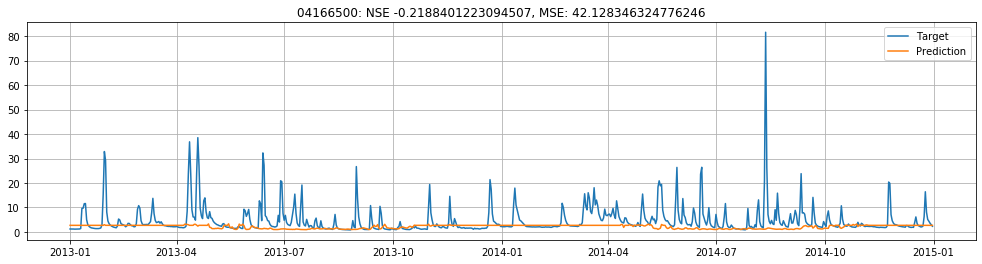

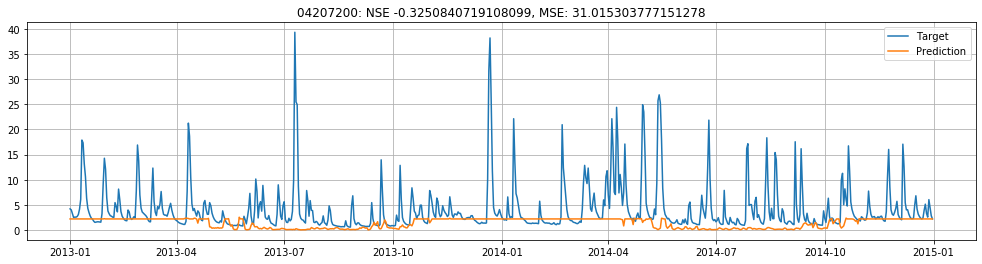

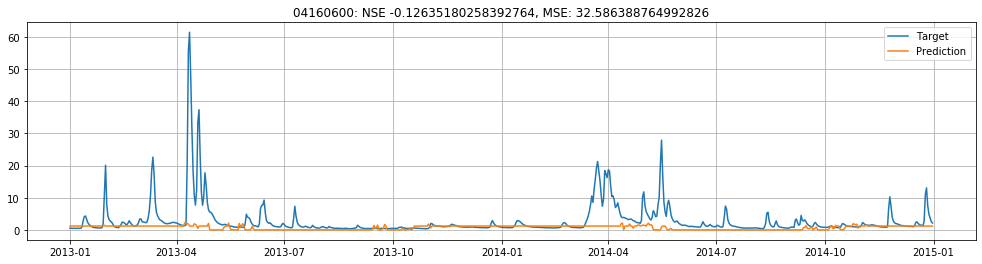

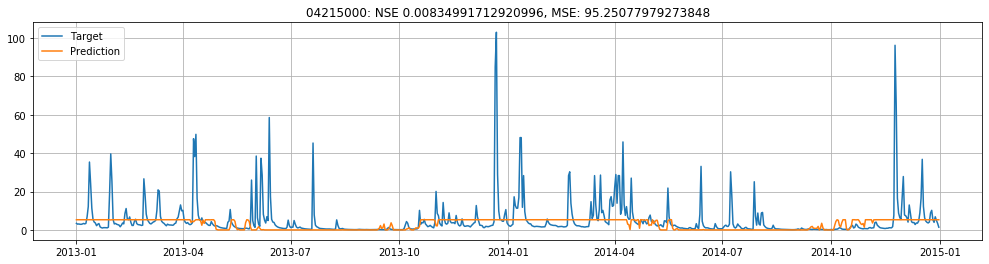

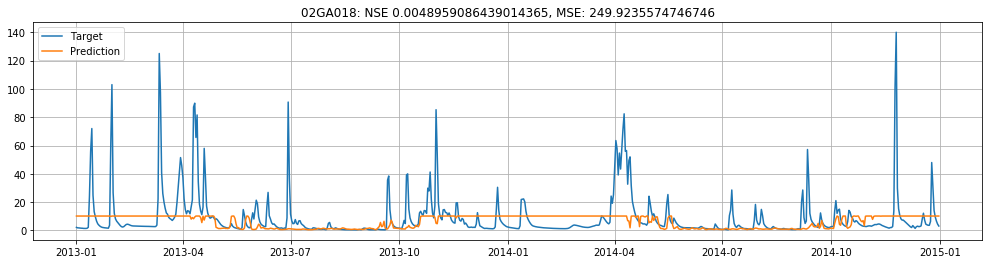

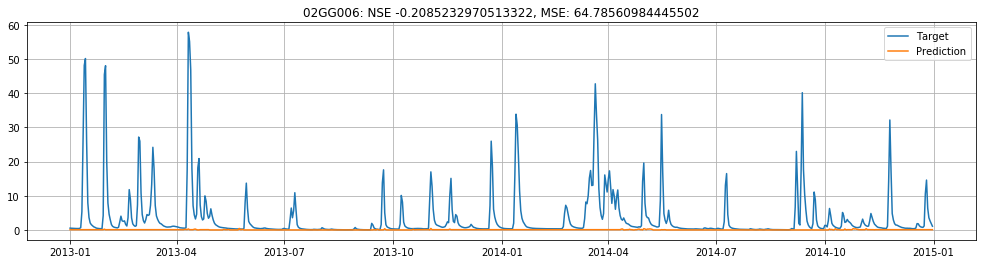

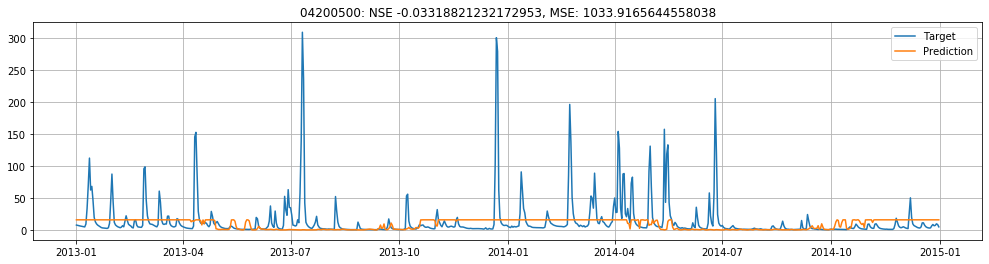

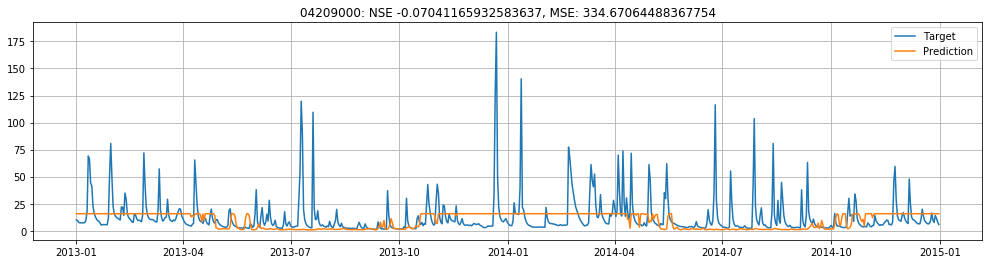

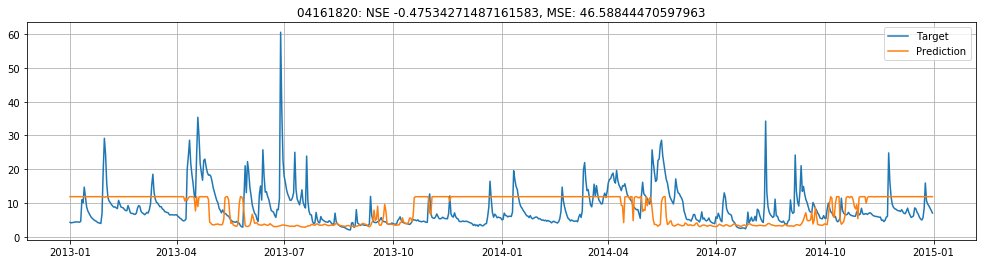

In [79]:
actuals = test_dataset.data_runoff.copy()
if len(actuals['date'].unique()) != len(predictions):
    print('Warning: length of prediction {} and actuals {} does not match.'.format(len(predictions), len(actuals['date'].unique())))

nse_list = []
mse_list = []
predictions_df = pd.DataFrame(columns=actuals.columns)
for station in actuals['station'].unique():
    row, col = test_dataset.station_to_row_col[station]
    
    act = actuals[actuals['station'] == station].set_index('date')['runoff']
    if predictions.shape[0] != act.shape[0]:
        print('Warning: length of prediction {} and actuals {} does not match for station {}. Ignoring excess actuals.'.format(len(predictions), len(act), station))
        act = act.iloc[:predictions.shape[0]]
    pred = pd.DataFrame({'runoff': predictions[:,row,col]}, index=act.index)
    pred['station'] = station
    predictions_df = predictions_df.append(pred.reset_index(), sort=True)
    
    nse, mse = evaluate.evaluate_daily(station, pred['runoff'], act, writer=writer)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))
writer.add_scalar('nse_median', np.median(nse_list))

In [ ]:
writer.close()

In [ ]:
save_df = pd.merge(predictions_df.rename({'runoff': 'prediction'}, axis=1), actuals.rename({'runoff': 'actual'}, axis=1), 
                   on=['date', 'station'])[['date', 'station', 'prediction', 'actual']]
load_data.pickle_results('ConvLSTM_VIC', save_df, time_stamp)

In [ ]:
datetime.now().strftime('%Y%m%d-%H%M%S')